In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import joblib
import tensorflow as tf
import keras
import cv2
import albumentations
from albumentations.core.transforms_interface import ImageOnlyTransform
from keras.layers import Input
from keras import backend as K 
from keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers, models, optimizers 
from keras.applications import ResNet50
from keras.models import Sequential, Model
from keras.layers import concatenate
from keras.utils.vis_utils import plot_model
from classification_models.keras import Classifiers
# pip install image-classifiers
from albumentations.augmentations import functional as F

Using TensorFlow backend.


In [2]:
DATA_PATH = '../input/bengaliai-cv19/'
TRAIN_DIR = DATA_PATH + 'train_crop_image/'

IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 30
PATIENT = 5

MODEL_PATH = '../model_ckpt/'
MODEL_NAME = 'baseline_v6.hdf5'
label = pd.read_csv(DATA_PATH+'train_label_folds.csv')

In [3]:
label.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,id,fold
0,Train_0,15,9,5,ক্ট্রো,0,2
1,Train_1,159,0,0,হ,1,3
2,Train_2,22,3,5,খ্রী,2,1
3,Train_3,53,2,2,র্টি,3,4
4,Train_4,71,9,5,থ্রো,4,2


In [4]:
Classifier, preprocess_input = Classifiers.get('seresnext50')
base_model = Classifier((IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
sub_model = Classifier((IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)

In [5]:
def build_model(image_size, base_model):
    x_in = layers.Input(shape=(image_size, image_size, 1))
    x = layers.Conv2D(3, (1,1), padding='same', activation = 'relu')(x_in)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    
    sub_x_in = layers.Input(shape=(image_size, image_size, 1))
    sub_x = layers.Conv2D(3, (1,1), padding='same', activation = 'relu')(sub_x_in)
    sub_x = sub_model(sub_x)
    sub_model.name = 'sub'
    sub_x = layers.GlobalAveragePooling2D()(sub_x)
    sub_x = layers.Dropout(0.5)(sub_x)
    
    merged_layers = concatenate([x, sub_x])
    
    out_grapheme = layers.Dense(168, activation='softmax', name='grapheme')(merged_layers)
    out_vowel = layers.Dense(11, activation='softmax', name='vowel')(merged_layers)
    out_consonant = layers.Dense(7, activation='softmax', name='consonant')(merged_layers)
    
    model = Model(inputs=[x_in, sub_x_in], outputs=[out_grapheme, out_vowel, out_consonant])
    model.summary()
    
    optimizer = optimizers.Adam(lr=0.001)
# multi output compile
    model.compile(optimizer,
                  loss={'grapheme': 'sparse_categorical_crossentropy',
                        'vowel': 'sparse_categorical_crossentropy',
                        'consonant': 'sparse_categorical_crossentropy'},
                  
                  loss_weights={'grapheme': 0.5,        ## Set weights
                                'vowel': 0.25,
                                'consonant': 0.25},
                  
                  metrics={'grapheme': 'acc',
                           'vowel': 'acc',
                           'consonant': 'acc'}
                 )

    return model

In [6]:
# 경로
def get_callback(model_name, patient):
    
    ES = EarlyStopping(
        monitor='val_loss', 
        patience=patient, 
        mode='min', 
        verbose=1)
    
    RR = ReduceLROnPlateau(
        monitor = 'val_loss', 
        factor = 0.1, 
        patience = 2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='min')
    
    MC = ModelCheckpoint(
        filepath=MODEL_PATH+model_name, 
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True, 
        mode='min')

    return [ES, RR, MC]

In [7]:
model = build_model(IMAGE_SIZE, base_model);
model.load_weights(MODEL_PATH+MODEL_NAME)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1163 (Conv2D)            (None, 128, 128, 3)  6           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1164 (Conv2D)            (None, 128, 128, 3)  6           input_2[0][

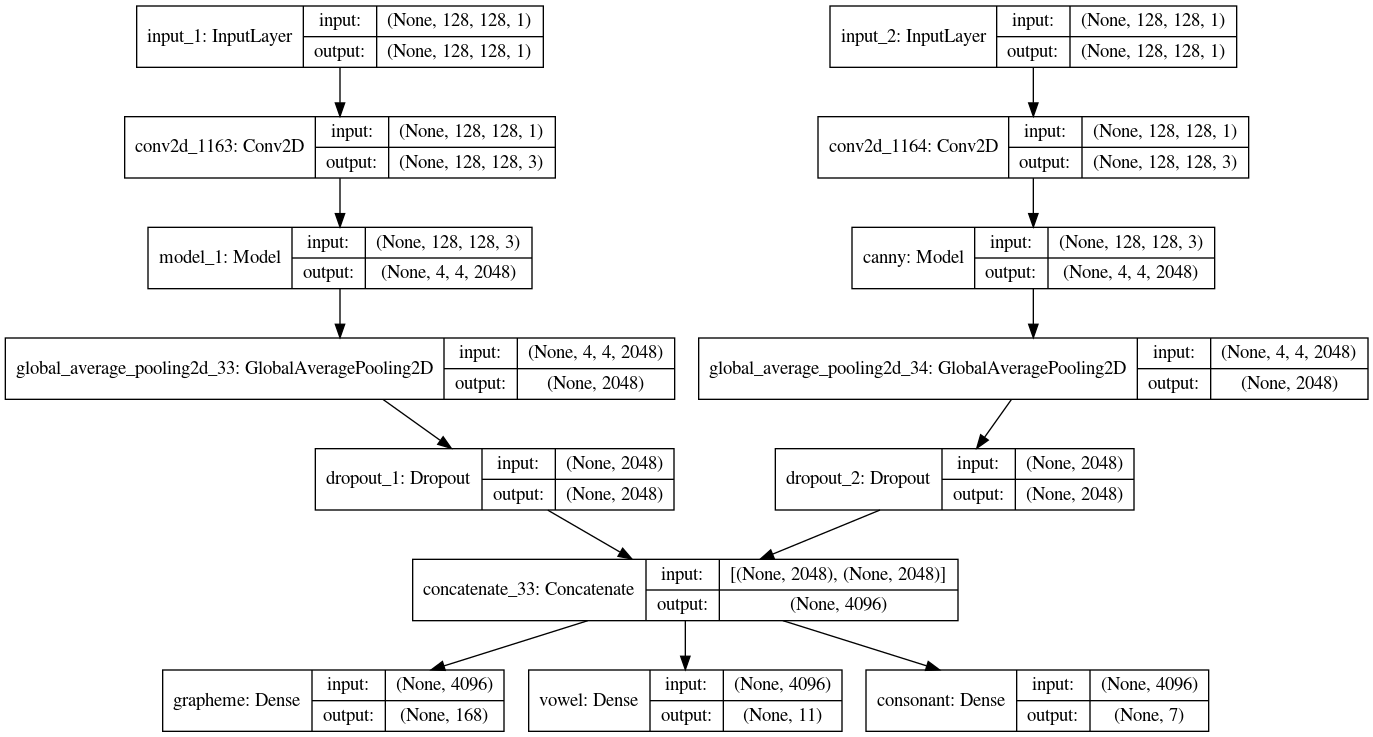

In [8]:
plot_model(model, to_file='merged_model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
#split train_label by fold (5fold)
label['id'] = label['id'].apply(lambda x : 'Train_'+str(x)+'.jpg')
val_label = label[label['fold']==4]
train_label = label[label['fold']!=4]

In [11]:
print(train_label['fold'].unique())
print(val_label['fold'].unique())

[2 3 1 0]
[4]


In [12]:
TRAIN_DIR

'../input/bengaliai-cv19/train_crop_image/'

In [13]:
AUGMENTATIONS_TRAIN = albumentations.Compose([
    albumentations.Flip(p=0.25),
    albumentations.GaussianBlur(p=0.25),
    albumentations.HorizontalFlip(p=0.25), 
    albumentations.Rotate(limit=20, p=0.5),
    albumentations.RandomRotate90(p=0.25)
])

def preprocessor(image):
#     print('original')
#     plt.imshow(image.reshape(128,128))
#     plt.show()
    image = (AUGMENTATIONS_TRAIN(image=image)["image"])
#     print('aug')
#     plt.imshow(image.reshape(128,128))
#     plt.show()
    return image

In [14]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function=preprocessor
)

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_label,
            directory=TRAIN_DIR,
            x_col='id',
            y_col=['grapheme_root','vowel_diacritic','consonant_diacritic'],
            target_size= (IMAGE_SIZE, IMAGE_SIZE),
            color_mode='grayscale',
            class_mode='multi_output',
            batch_size=BATCH_SIZE,
            seed=42
            )

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_label,
    directory=TRAIN_DIR,
    x_col='id',
    y_col=['grapheme_root','vowel_diacritic','consonant_diacritic'],
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    class_mode='multi_output',
    batch_size=BATCH_SIZE,
    seed=42
    )

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_label.index) / BATCH_SIZE,
    epochs= EPOCHS,
    validation_data= valid_generator,
    validation_steps=len(val_label.index) / BATCH_SIZE,
    callbacks = get_callback(MODEL_NAME, PATIENT),
    verbose=1)

In [ ]:
history = model.fit_generator(
    generator = train_generator(BATCH_SIZE),
    steps_per_epoch=len(train_label) / BATCH_SIZE,
    epochs= EPOCHS,
    validation_data= valid_generator(BATCH_SIZE),
    validation_steps=len(val_label) / BATCH_SIZE,
    callbacks = get_callback(MODEL_NAME, PATIENT),
    verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
Found 40168 validated image filenames.
Found 160672 validated image filenames.
5021/5021 [==============================] - 2415s 481ms/step - loss: 0.3506 - grapheme_loss: 0.5197 - vowel_loss: 0.1966 - consonant_loss: 0.1662 - grapheme_acc: 0.8517 - vowel_acc: 0.9414 - consonant_acc: 0.9478 - val_loss: 0.2191 - val_grapheme_loss: 0.3335 - val_vowel_loss: 0.1062 - val_consonant_loss: 0.1033 - val_grapheme_acc: 0.9066 - val_vowel_acc: 0.9693 - val_consonant_acc: 0.9682

Epoch 00001: val_loss improved from inf to 0.21910, saving model to ../model_ckpt/baseline_v6.hdf5
Epoch 2/30
5021/5021 [==============================] - 2102s 419ms/step - loss: 0.2874 - grapheme_loss: 0.4221 - vowel_loss: 0.1631 - consonant_loss: 0.1424 - grapheme_acc: 0.8783 - vowel_acc: 0.9524 - consonant_acc: 0.9557 - val_loss: 0.1883 - val_grapheme_loss: 0.2733 - val_vowel_loss: 0.1124 - val_consonant_loss: 0